# K-Means Clustering

Hopkins Statistic: 0.1742660329464369


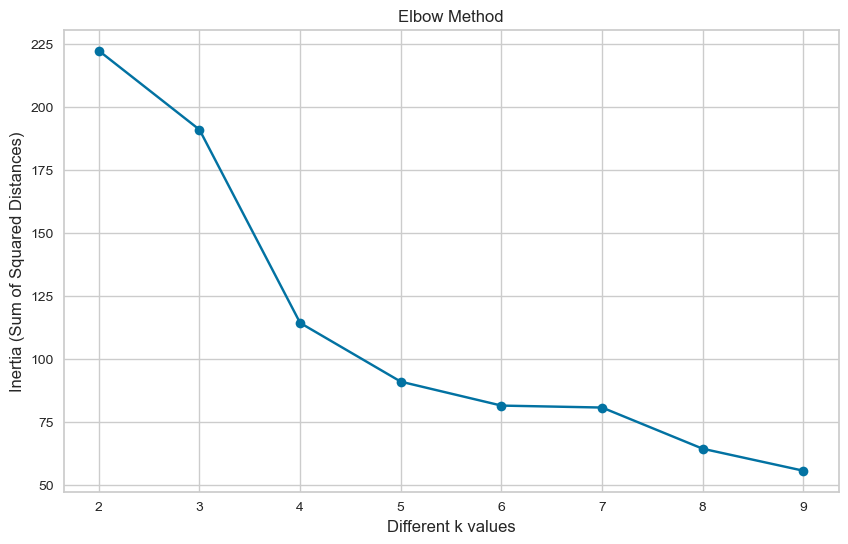

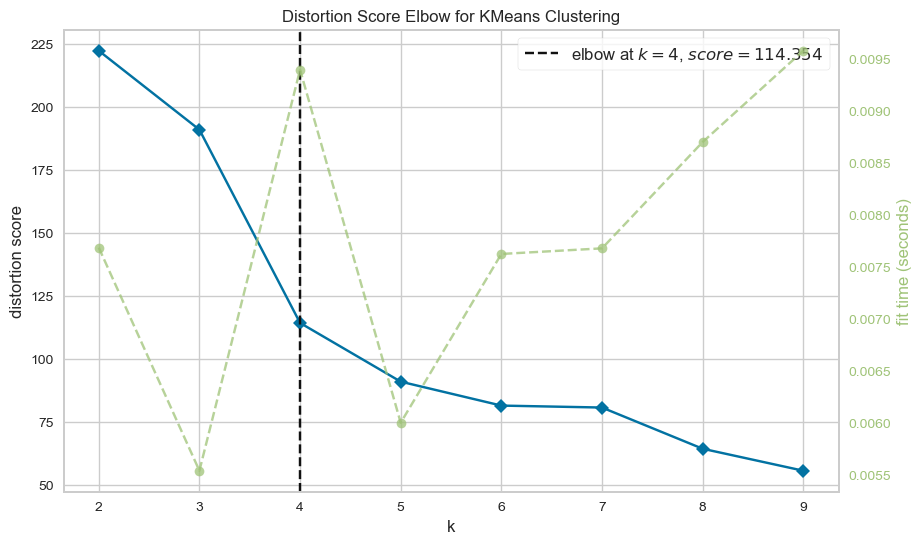

For n_clusters=2, the silhouette score is 0.5817500491982808
For n_clusters=3, the silhouette score is 0.4798814508199818
For n_clusters=4, the silhouette score is 0.3850454053045392
For n_clusters=5, the silhouette score is 0.34503345350274617
For n_clusters=6, the silhouette score is 0.33394323040061763
For n_clusters=7, the silhouette score is 0.2664290993719981
For n_clusters=8, the silhouette score is 0.34162906041313373


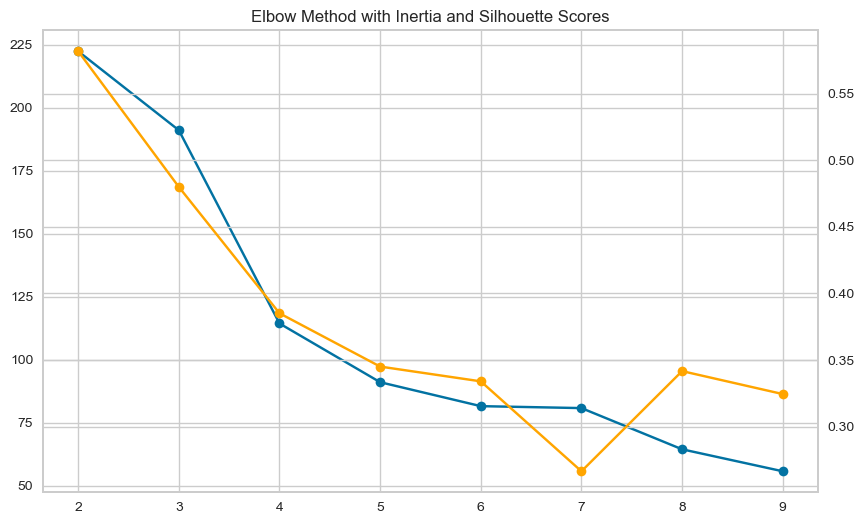

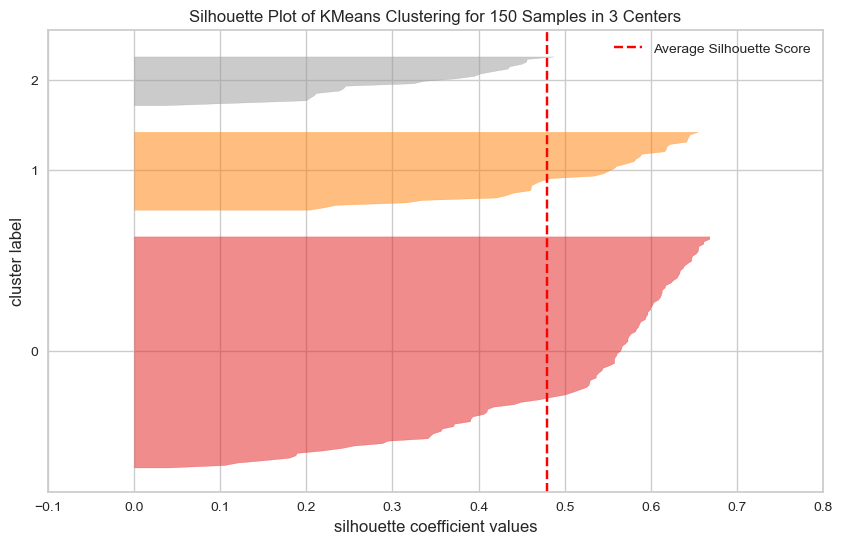

target              setosa  versicolor  virginica
predicted_clusters                               
0                        0          46         50
1                       33           0          0
2                       17           4          0
Adjusted Rand Index (ARI): 0.432804702527474


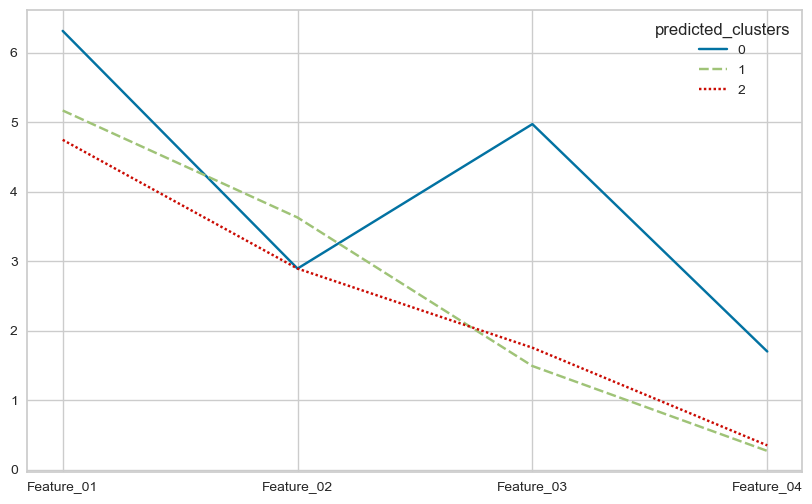

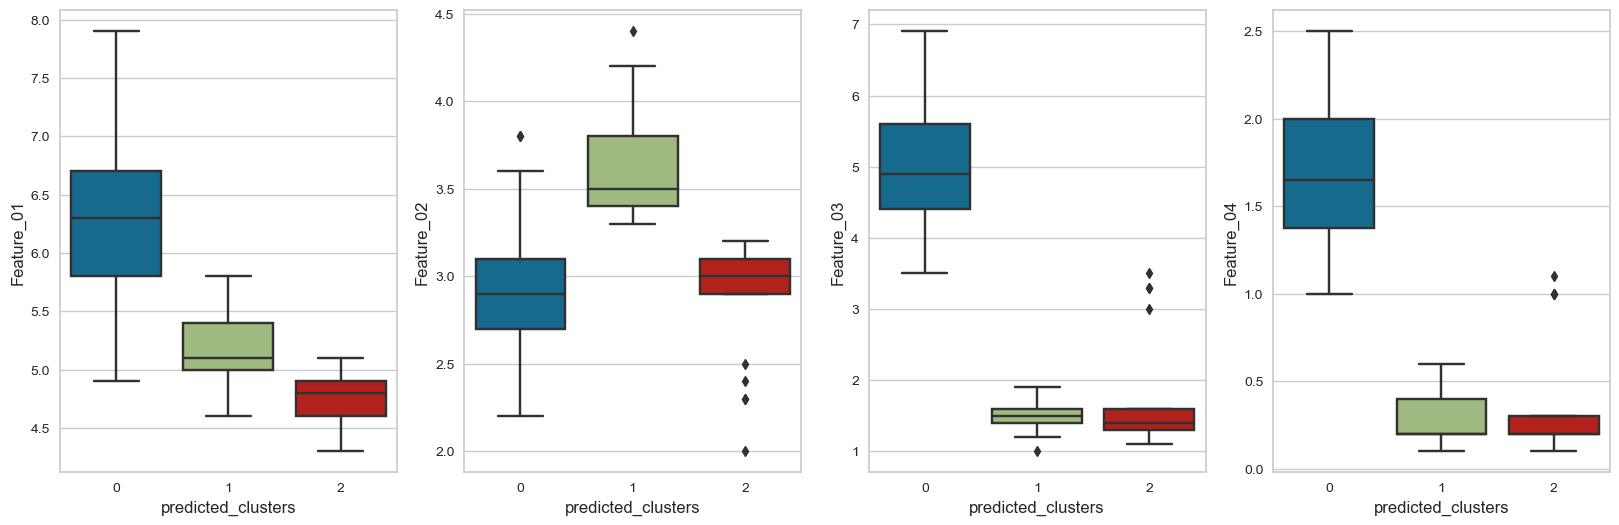

In [6]:
# K-Means Clustering Master Notebook

# 1a) Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.neighbors import BallTree
import warnings  # For ignoring unnecessary warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10,6)

# ------------------------ #

# 1b) Load the Dataset
df = pd.read_csv("sample.csv")  # Load your dataset here
df.head()

# 1c) Dropping Target Variable(Run only if there is target variable available)
X = df.drop("target", axis=1)  # Exclude the target variable from the clustering features

# 1d) Data Preprocessing - Scaling Features
# Scaling the dataset (excluding target variable if necessary)
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)

# K-Means Clustering Master Notebook

# 2) Perform Hopkins Test to Check Clusterability
def hopkins_statistic(data, sample_size):
    """
    This function calculates the Hopkins statistic to assess the tendency of a dataset to form clusters.
    """
    # Convert data to a DataFrame if it is not already one
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)
    
    # Ensure the sample size is valid
    if sample_size > len(data):
        raise ValueError('Sample size cannot exceed the number of data points.')
    
    # Randomly sample points from the dataset
    sampled_points = data.sample(n=sample_size)
    
    # Create a BallTree for efficient nearest neighbor search
    tree = BallTree(data, leaf_size=2)
    nearest_distances, _ = tree.query(sampled_points, k=2)
    distances_sampled = nearest_distances[:, 1]
    
    # Generate random points in the same feature space
    min_values = data.min()
    max_values = data.max()
    random_points = np.random.uniform(min_values, max_values, (sample_size, data.shape[1]))
    random_points_df = pd.DataFrame(random_points)
    
    # Calculate the nearest neighbor distances for random points
    dist_random, _ = tree.query(random_points_df, k=1)
    distances_random = dist_random[:, 0]
    
    # Compute the Hopkins statistic
    sum_sampled_distances = np.sum(distances_sampled)
    sum_random_distances = np.sum(distances_random)
    
    if sum_sampled_distances + sum_random_distances == 0:
        raise ValueError('Invalid data: Sum of distances is zero.')
    
    hopkins_value = sum_sampled_distances / (sum_sampled_distances + sum_random_distances)
    return hopkins_value

# Perform the Hopkins test for the entire dataset
hopkins_value = hopkins_statistic(X_scaled, X_scaled.shape[0])
print(f"Hopkins Statistic: {hopkins_value}")

# 3) Choose Optimal Number of Clusters

## 3a) Elbow Method
ssd = []  # Sum of Squared Distances (Inertia)
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    ssd.append(model.inertia_)
    
# Plot Elbow Method results
plt.plot(K, ssd, "bo-")
plt.xlabel("Different k values")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method")
plt.show()

## 3b) KElbowVisualizer using Yellowbrick
model_ = KMeans(random_state=42)
visualizer = KElbowVisualizer(model_, k=(2, 10))
visualizer.fit(X_scaled)
visualizer.show()

## 3c) Silhouette Analysis
range_n_clusters = range(2, 9)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

## 3d) Elbow and Silhouette Combined
inertia_scores = []
silhouette_scores = []
for i in range(2, 10):
    model = KMeans(n_clusters=i, random_state=42)
    labels = model.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    inertia = model.inertia_
    inertia_scores.append(inertia)
    silhouette_scores.append(silhouette)

# Plot Elbow and Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), inertia_scores, label='Inertia', marker='o')
plt.twinx()
plt.plot(range(2, 10), silhouette_scores, label='Silhouette Score', marker='o', color='orange')
plt.title('Elbow Method with Inertia and Silhouette Scores')
plt.show()

## 3e) Silhouette Visualizer
model3 = KMeans(n_clusters=3, random_state=42)
visualizer = SilhouetteVisualizer(model3)
visualizer.fit(X_scaled)
visualizer.show();

# 4a) Train Final KMeans Model
final_model = KMeans(n_clusters=3, random_state=42)
clusters = final_model.fit_predict(X_scaled)
df["predicted_clusters"] = clusters  # Add predicted clusters to the original dataset

# 4b) Evaluate Clustering Performance
# Evaluate with crosstab (if true labels available)
ct = pd.crosstab(df["predicted_clusters"], df["target"])
print(ct)

# Evaluate with Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(df["target"], df["predicted_clusters"])
print(f"Adjusted Rand Index (ARI): {ari_score}")

# 5a) Feature Selection Analysis using Line Plot
clus_pred = df.iloc[:, [0,1,2,3,5]].groupby("predicted_clusters").mean().T
sns.lineplot(data=clus_pred)

# 5b)Feature Selection Analysis using Boxplot
plt.figure(figsize=(20, 6))
plt.subplot(141)
sns.boxplot(y="Feature_01", x="predicted_clusters", data=df)
plt.subplot(142)
sns.boxplot(y="Feature_02", x="predicted_clusters", data=df)
plt.subplot(143)
sns.boxplot(y="Feature_03", x="predicted_clusters", data=df)
plt.subplot(144)
sns.boxplot(y="Feature_04", x="predicted_clusters", data=df)
plt.show()